<a href="https://colab.research.google.com/github/theclosedbook/TensorFlow/blob/main/Transfer_learning_part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scalling up(Food Vision mini)
What we're going to cover

We're going to go through the follow with TensorFlow:

    Downloading and preparing 10% of the Food101 data (10% of training data)
    Training a feature extraction transfer learning model on 10% of the Food101 training data
    Fine-tuning our feature extraction model
    Saving and loaded our trained model
    Evaluating the performance of our Food Vision model trained on 10% of the training data
        Finding our model's most wrong predictions
    Making predictions with our Food Vision model on custom images of food


In [1]:
# check to see if we are using gpu
!nvidia-smi

Thu Feb 29 16:53:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions
In previous notebooks we have created a series of helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-29 16:53:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-29 16:53:21 (57.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook

from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

## 101 Food Classes : working with less data
Our goal is to beat the original Food101 paper with 10% training data

In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-02-29 16:53:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.207, 209.85.146.207, 209.85.147.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   121MB/s    in 16s     

2024-02-29 16:53:41 (99.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How manu images/classes
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ravioli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images 

In [6]:
# Setup the data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode ="categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode="categorical",
                                                             image_size=IMG_SIZE,
                                                             shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layer) Functional EfficiNetB0 backboned-model (we'll create our own output layer)
* Feature extract for 5 full passes (5 epochs on the train dataset and validation on 15% of the test data, to save epoch time)

In [7]:
# Create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weight_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)


In [8]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [9]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [12]:
# Fit the model
history_all_10 = model.fit(train_data_all_10_percent,
                           epochs=5,
                           validation_data=test_data,
                           validation_steps = int(0.15 * len(test_data)),
                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 187s 744ms/step - loss: 3.3729 - accuracy: 0.2722 - val_loss: 2.6236 - val_accuracy: 0.4094
Epoch 2/5
237/237 [==============================] - 130s 546ms/step - loss: 2.1908 - accuracy: 0.5030 - val_loss: 2.1167 - val_accuracy: 0.4918
Epoch 3/5
237/237 [==============================] - 121s 510ms/step - loss: 1.8231 - accuracy: 0.5692 - val_loss: 1.9478 - val_accuracy: 0.5082
Epoch 4/5
237/237 [==============================] - 105s 441ms/step - loss: 1.5996 - accuracy: 0.6099 - val_loss: 1.8451 - val_accuracy: 0.5307
Epoch 5/5
237/237 [==============================] - 99s 415ms/step - loss: 1.4505 - accuracy: 0.6441 - val_loss: 1.8109 - val_accuracy: 0.5352


In [15]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 54s 68ms/step - loss: 1.5701 - accuracy: 0.5889


[1.570084810256958, 0.5889108777046204]

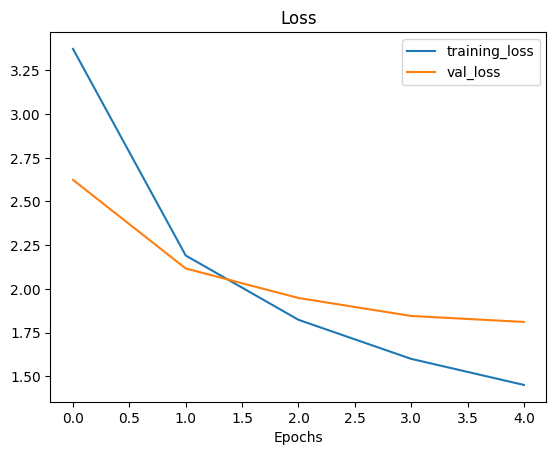

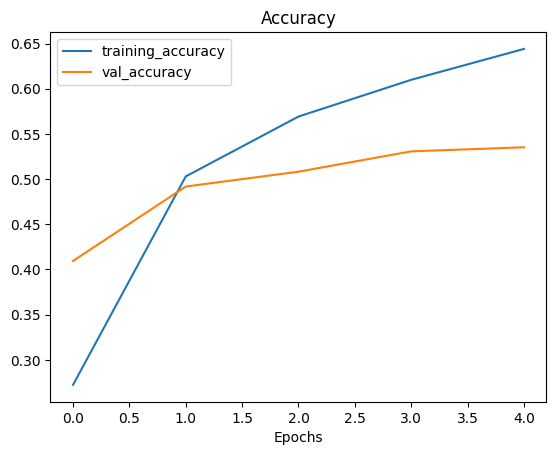

In [13]:
plot_loss_curves(history_all_10)

### Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable=True

# Refreeze every layer expect the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Complie the model

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [18]:
# what layers in the model are trainable
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [19]:
# check which layers are trainable in our base_model

for layer_number,layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [20]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# fine tune our model
history_10_fine_tune = model.fit(train_data_all_10_percent,
                                 epochs=fine_tune_epochs,
                                 validation_data=test_data,
                                 validation_steps = int(0.15*len(test_data)),
                                 initial_epoch = history_all_10.epoch[-1])

Epoch 5/10
237/237 [==============================] - 80s 295ms/step - loss: 1.5055 - accuracy: 0.6034 - val_loss: 1.9872 - val_accuracy: 0.4772
Epoch 6/10
237/237 [==============================] - 62s 259ms/step - loss: 1.0725 - accuracy: 0.7044 - val_loss: 2.0517 - val_accuracy: 0.4809
Epoch 7/10
237/237 [==============================] - 63s 266ms/step - loss: 0.8273 - accuracy: 0.7675 - val_loss: 1.8711 - val_accuracy: 0.5326
Epoch 8/10
237/237 [==============================] - 57s 238ms/step - loss: 0.6438 - accuracy: 0.8123 - val_loss: 2.0499 - val_accuracy: 0.4934
Epoch 9/10
237/237 [==============================] - 60s 252ms/step - loss: 0.5154 - accuracy: 0.8508 - val_loss: 2.1762 - val_accuracy: 0.5032
Epoch 10/10
237/237 [==============================] - 56s 234ms/step - loss: 0.4335 - accuracy: 0.8704 - val_loss: 2.5087 - val_accuracy: 0.4568


In [23]:
all_classes_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 53s 67ms/step - loss: 1.9546 - accuracy: 0.5584


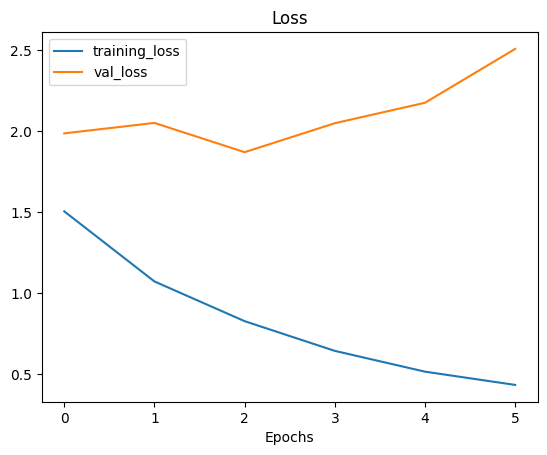

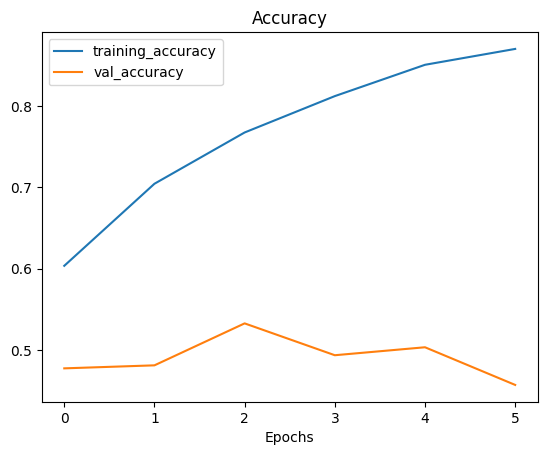

In [22]:
plot_loss_curves(history_10_fine_tune)

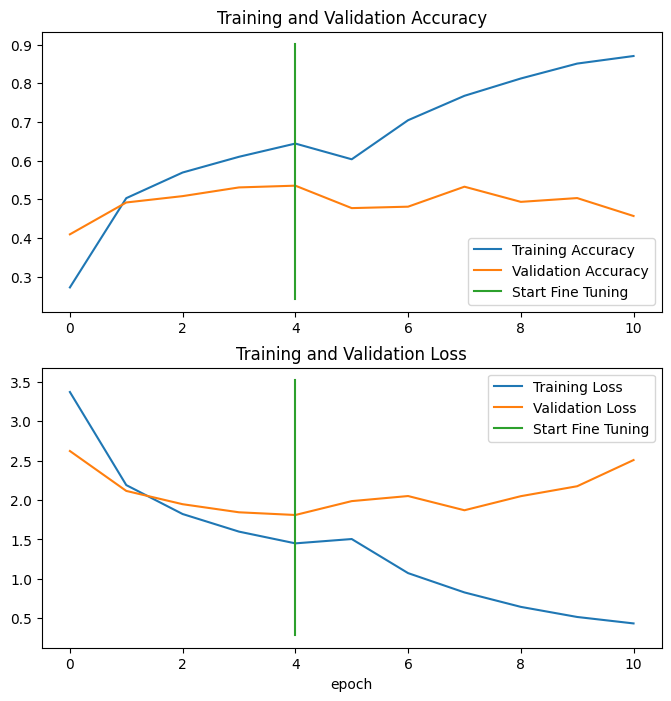

In [26]:
# compare history
compare_historys(original_history=history_all_10,
                 new_history=history_10_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, EfficientNetB0 was trained on ImageNet which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

In [27]:
# Saving fine-tune model

#model.save("drive/MyDrive/folder_name/file_name")

# Load and evaluate the saved model

# loaded_model = tf.keras.models.load_model("drive/MyDrive/folder_name/file_name")

Evaluating the performance of the big dog model across all different classes
We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

In [28]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path


--2024-02-29 18:10:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   105MB/s    in 0.4s    

2024-02-29 18:10:41 (105 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]

